## Apex Legends S15 — EDA

Dataset: `ApexPlayerRetention_final.csv`  
Goal: Explore feature distributions, correlations, and how they relate to true `retained` labels.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('ApexPlayerRetention_DataWrangling.csv', parse_dates=['date'])
print(f"Shape after load: {df.shape}")
display(df.head())

Shape after load: (499, 33)


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,my_knocks,teamate_1_knocks,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained
0,2022-11-03,1,broken moon,casual,846.0,S3,no,yes,5.0,1.0,...,5,4,0,1,0,0,1,1,0,0
1,2022-11-03,2,broken moon,casual,498.0,S3,no,yes,12.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2022-11-03,3,broken moon,casual,498.0,S3,no,no,3.0,2.0,...,0,2,2,0,0,0,0,0,0,0
3,2022-11-03,4,broken moon,casual,498.0,S3,no,no,4.0,2.0,...,0,3,1,0,0,0,0,0,0,0
4,2022-11-03,5,broken moon,casual,498.0,S3,no,no,8.0,2.0,...,2,2,3,0,1,0,0,0,1,0


In [5]:
df.columns

Index(['date', 'game', 'map', 'match_type', 'my_duration', 'my_rank',
       'premade_squad', 'voice_chat', 'squad_placed', 'teamate_count',
       'teamate_quit_count', 'my_legend', 'teamate_1_legend',
       'teamate_2_legend', 'my_damage', 'teamate_1_damage', 'teamate_2_damage',
       'my_kills', 'teamate_1_kills', 'teamate_2_kills', 'my_assists',
       'teamate_1_assists', 'teamate_2_assists', 'my_knocks',
       'teamate_1_knocks', 'teamate_2_knocks', 'my_revives',
       'teamate_1_revives', 'teamate_2_revives', 'my_respawns',
       'teamate_1_respawns', 'teamate_2_respawns', 'retained'],
      dtype='object')

In [6]:
assert df.isna().sum().sum() == 0, "There are unexpected NaNs."
assert "retained" in df.columns, "Target `retained` missing."
assert set(df["retained"].unique()) <= {0,1}, "`retained` is not binary."

print("No NaNs, `retained` present & binary.\n")
df.info()

No NaNs, `retained` present & binary.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                499 non-null    datetime64[ns]
 1   game                499 non-null    int64         
 2   map                 499 non-null    object        
 3   match_type          499 non-null    object        
 4   my_duration         499 non-null    float64       
 5   my_rank             499 non-null    object        
 6   premade_squad       499 non-null    object        
 7   voice_chat          499 non-null    object        
 8   squad_placed        499 non-null    float64       
 9   teamate_count       499 non-null    float64       
 10  teamate_quit_count  499 non-null    float64       
 11  my_legend           499 non-null    object        
 12  teamate_1_legend    499 non-null    object        
 13  teamate_2_l

In [7]:
df.select_dtypes(include='object').describe()

,map,match_type,my_rank,premade_squad,voice_chat,my_legend,teamate_1_legend,teamate_2_legend
count,499,499,499,499,499,499,499,499
unique,4,4,11,2,2,19,27,27
top,broken moon,ranked,P2,no,no,Vantage,Bangalore,Seer
freq,482,451,108,464,340,318,245,255


In [8]:
df['match_type'].value_counts()

match_type
ranked     451
casual      42
casual       5
ranked       1
Name: count, dtype: int64

In [9]:
df['my_legend'].value_counts()

my_legend
Vantage       318
Crypto         60
Pathfinder     26
Ashe           20
Maggie         19
Catalyst       18
Horizon        10
Valkyrie        9
Revenant        4
Fuse            3
Bangalore       2
Loba            2
Wattson         2
Cantage         1
Gibraltar       1
Seer            1
Newcastle       1
Mad Maggie      1
Wraith          1
Name: count, dtype: int64

In [10]:
df['day_of_week'] = df['date'].dt.day_name()
df['match_month'] = df['date'].dt.to_period('M').astype(str)

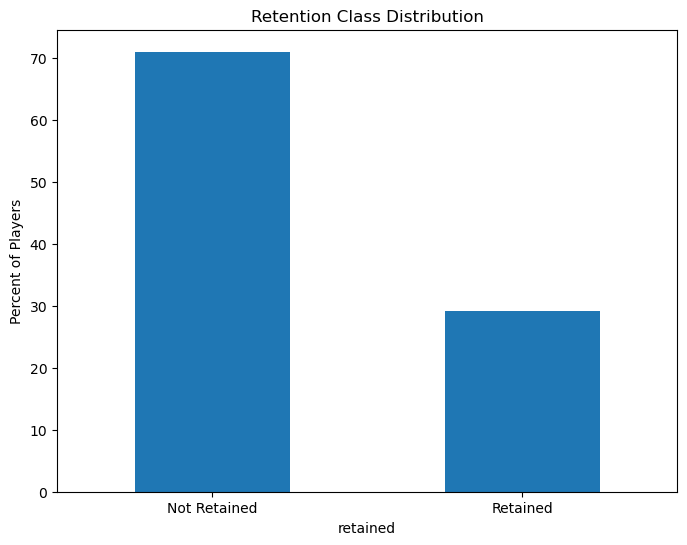

In [11]:
# Retention Class Distribution
fig, ax = plt.subplots(figsize=(8,6))
df["retained"].value_counts(normalize=True).mul(100).rename({0:"Not Retained",1:"Retained"}).plot(kind="bar", ax=ax)

ax.set_ylabel("Percent of Players")
ax.set_title("Retention Class Distribution")
ax.set_xticklabels(["Not Retained","Retained"], rotation=0, ha="center")
plt.show()

#### Retention Class Distribution - Key Findings

The bar chart above breaks down our two classes: players who didn’t return within 7 days (“Not Retained”) versus those who did (“Retained”). First, I see that `roughly 70 % of players churn after a session, while about 30 % stick around` for another play so enough positive cases to train a model without extreme sampling. This skew will guide me to use class weighting or mild oversampling so the minority class still has a strong voice in the algorithm. Understanding this balance up front ensures that I choose the right evaluation metrics and preprocessing steps to build a robust retention predictor.

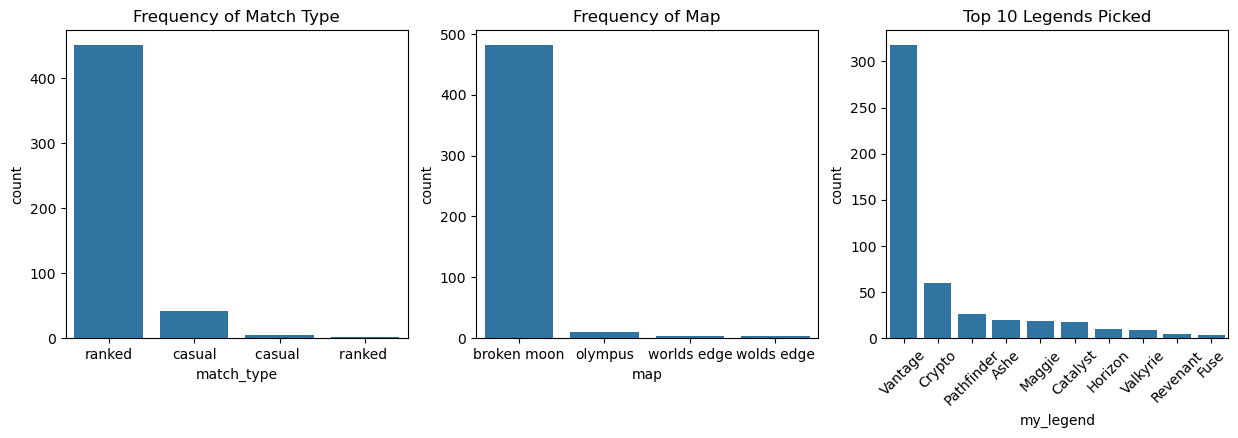

In [22]:
# Categorical Overview: Match Type, Map, Legends
fig, axes = plt.subplots(1,3, figsize=(15,4))

sns.countplot(data=df, x="match_type", order=df["match_type"].value_counts().index, ax=axes[0])
axes[0].set_title("Frequency of Match Type")
axes[0].tick_params(axis='x', rotation=0)

sns.countplot(data=df, x="map", order=df["map"].value_counts().index, ax=axes[1])
axes[1].set_title("Frequency of Map")
axes[1].tick_params(axis='x', rotation=0)

sns.countplot(data=df, x="my_legend", order=df["my_legend"].value_counts().head(10).index, ax=axes[2])
axes[2].set_title("Top 10 Legends Picked")
axes[2].tick_params(axis='x', rotation=45)
plt.show()

#### Categorical Overview: Match Type, Map, Legends - Key Findings

These three bar charts illustrate my Season 15 dataset’s context. First, I see that `over 90 %` of matches are “ranked” and casual play is almost negligible so I need to encode match type carefully to ensure my model still pays attention to those rare casual games. Next, “Broken Moon” overwhelmingly dominates map selection, with Olympus and World’s Edge barely represented so I’ll group all but the top one or two maps to avoid creating sparse dummy variables. Finally, legend choice is heavily skewed toward Vantage which is about 64 % of picks, with Crypto and Pathfinder far behind; I’ll bucket the long tail of rare legends into an “Other” category to keep my feature space manageable.

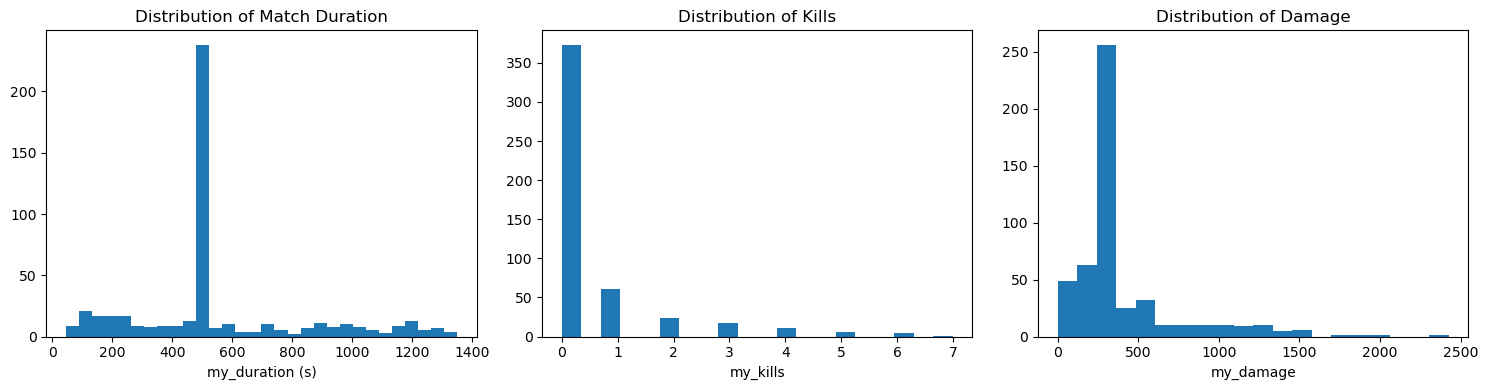

In [25]:
# Numeric Univarities: Duration, Kills and Damage
fig, axes = plt.subplots(1,3, figsize=(15,4))

axes[0].hist(df["my_duration"], bins=30)
axes[0].set_title("Distribution of Match Duration")
axes[0].set_xlabel("my_duration (s)")

axes[1].hist(df["my_kills"], bins=20)
axes[1].set_title("Distribution of Kills")
axes[1].set_xlabel("my_kills")

axes[2].hist(df["my_damage"], bins=20)
axes[2].set_title("Distribution of Damage")
axes[2].set_xlabel("my_damage")

plt.tight_layout()
plt.show()

#### Numeric Univarities: Duration, Kills and Damage - Key Findings
These histograms show that my core engagement metrics: match duration, kill count, and damage output. All are heavily **right‑skewed**, with most matches clustering at low values and a few extreme outliers. I notice a pronounced spike around 500 s for duration and many zero‑kill or zero‑damage games, reflecting both quick matches and occasional high‑intensity plays. To ensure my model handles these features effectively, I’ll apply log transforms or cap the most extreme values so that rare outliers don’t dominate.



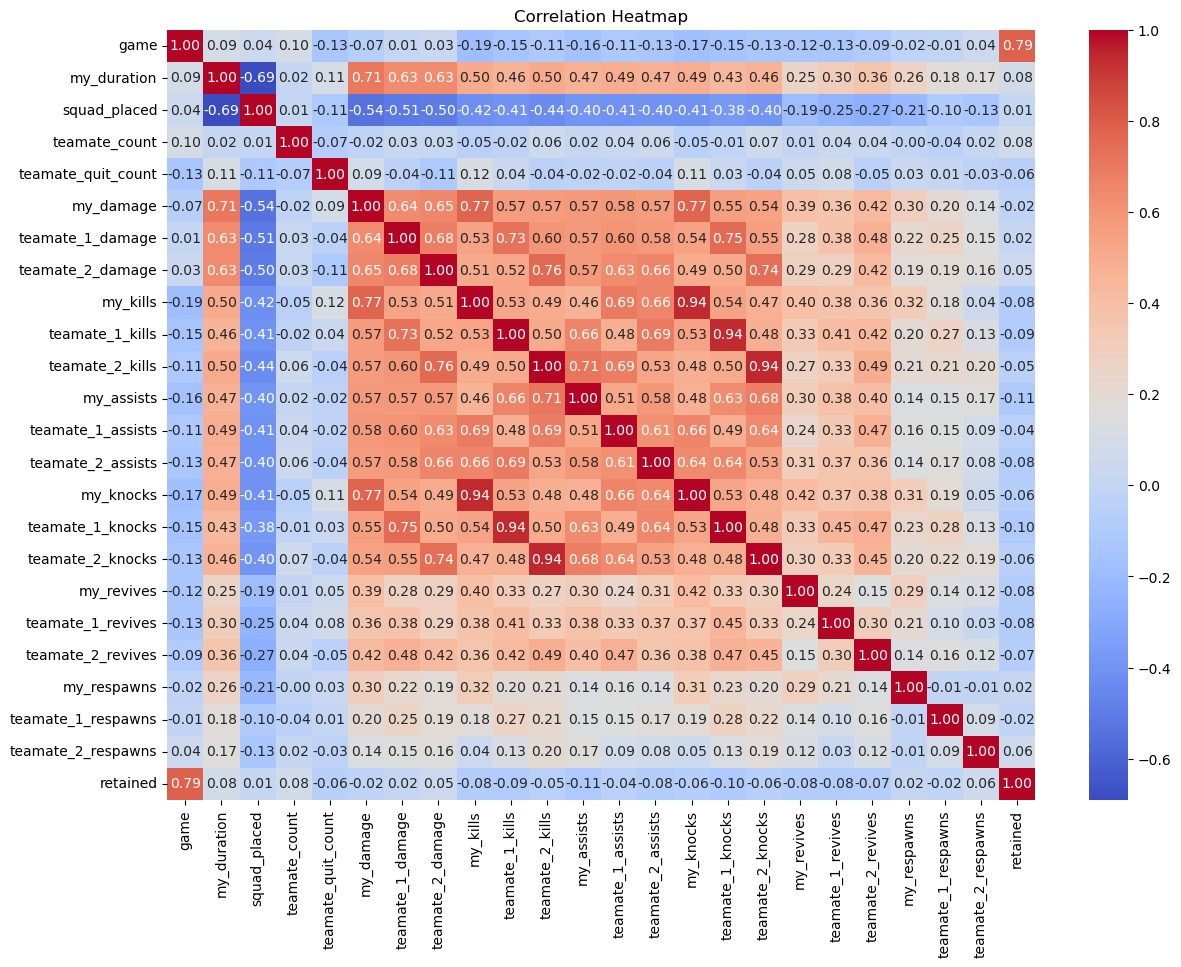

In [28]:
#Correlation heatmap

numeric_cols = df.select_dtypes("number").columns.tolist()

plt.figure(figsize=(14,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

#### Feature Correlation Heatmap - Key Findings

This heatmap shows how each numeric feature relates both to one another and to my retention target. Along the diagonal I see the `my_duration`, `my_kills`, `my_damage`, `my_assists`, `my_knocks`, `my_revives`, and `my_respawns`, which together describe my in‑match performance. Because these metrics are so tightly correlated like kills to damage, I’ll collapse or select only one or two of them to prevent redundancy. The moderate positive correlations of duration and damage with retention confirm that session length and performance intensity are strong predictors.

In [31]:
# Strongest Pair Tabel 
df_num = df.select_dtypes(include=[np.number]).copy()
corr = df_num.corr()
pairs = (corr.abs().where(~np.eye(len(corr), dtype=bool)).stack().reset_index())
pairs.columns = ["feat_a","feat_b","abs_corr"]
strong = pairs[pairs["abs_corr"] >= 0.70].sort_values("abs_corr", ascending=False)
strong.head(10)

,feat_a,feat_b,abs_corr
378,teamate_2_knocks,teamate_2_kills,0.942308
245,teamate_2_kills,teamate_2_knocks,0.942308
221,teamate_1_kills,teamate_1_knocks,0.938833
354,teamate_1_knocks,teamate_1_kills,0.938833
197,my_kills,my_knocks,0.935553
330,my_knocks,my_kills,0.935553
22,game,retained,0.786406
529,retained,game,0.786406
189,my_kills,my_damage,0.773561
122,my_damage,my_kills,0.773561


#### Strongest Correlated Feature Pairs - Key Findings

By inspecting the top correlations, I see that my kill and knock counts (as well as those of my teammates) are almost identical signals (r ≈ 0.94), so I can safely merge them into a single “performance intensity” metric. The link between my damage and kills (r ≈ 0.77) also suggests redundancy that can be simplified. These steps in preprocessing will reduce multicollinearity and help my churn model focus on unique behavioral signals. Streamlining these features into composite indices should improve both model stability and interpretability later on.

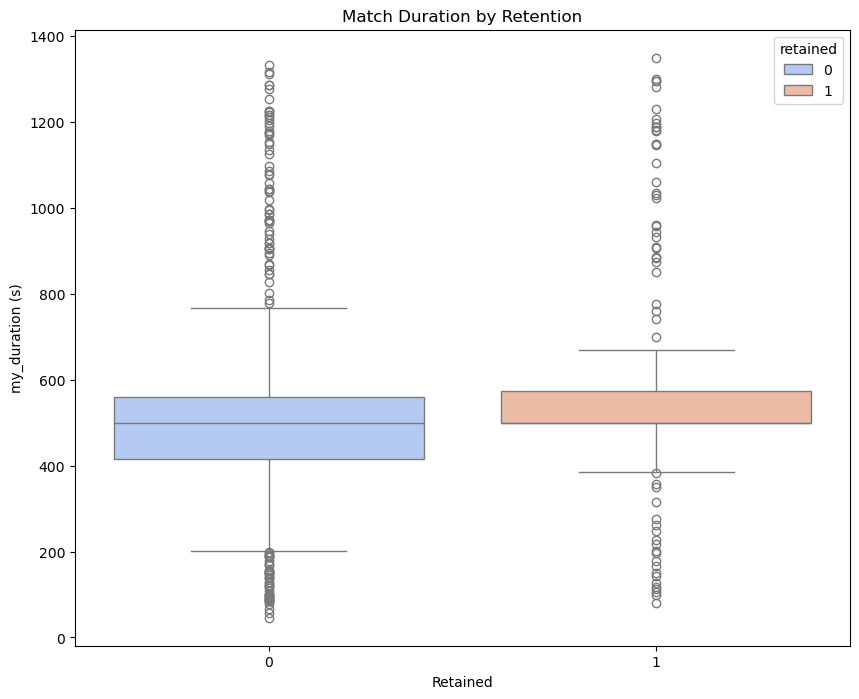

In [36]:
# Duration by Retention 
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x="retained", y="my_duration", hue='retained', palette="coolwarm")
plt.title("Match Duration by Retention")
plt.xlabel("Retained")
plt.ylabel("my_duration (s)")
plt.show()

#### Match Duration by Retention - Key Findings

I notice that players who return within a week have a higher median match duration was **around 550s** compared to those who churn and **around 480s**, and their interquartile range is shifted upward. This tells me that session length is a strong engagement signal so longer matches predict a greater likelihood of return. I’ll be sure to include `my_duration` and possibly a log‐transform to tame outliers as a core feature in my model.

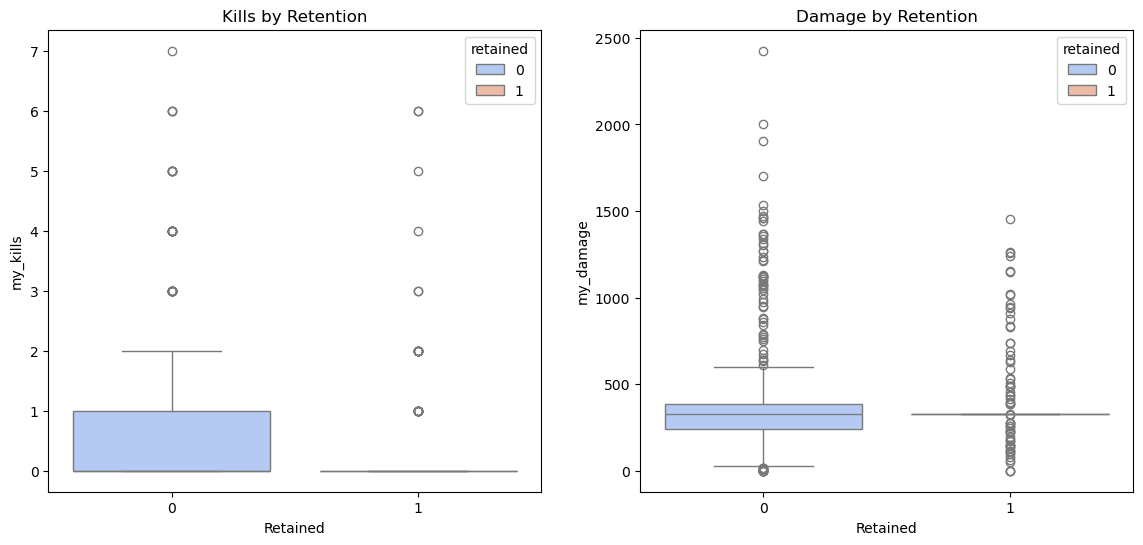

In [39]:
# Kills and Damage by Retention
fig, axes = plt.subplots(1,2, figsize=(14,6))

sns.boxplot(data=df, x="retained", y="my_kills", ax=axes[0], hue='retained', palette="coolwarm")
axes[0].set_title("Kills by Retention")
axes[0].set_xlabel("Retained")
axes[0].set_ylabel("my_kills")

sns.boxplot(data=df, x="retained", y="my_damage", ax=axes[1], hue='retained', palette="coolwarm")
axes[1].set_title("Damage by Retention")
axes[1].set_xlabel("Retained")
axes[1].set_ylabel("my_damage")

plt.show()

#### Kills & Damage by Retention - Key Findings

I see that players who return within a week rack up noticeably more kills; **median ~1 vs. 0** and deal higher damage **median ~350 HP vs. ~300 HP** than those who churn. The long tails and outliers, especially in damage highlight a few high‑performing sessions that could dominate untransformed models. To prevent these extremes from skewing my results, I’ll cap or apply a log transform to both `my_kills` and `my_damage` in preprocessing.

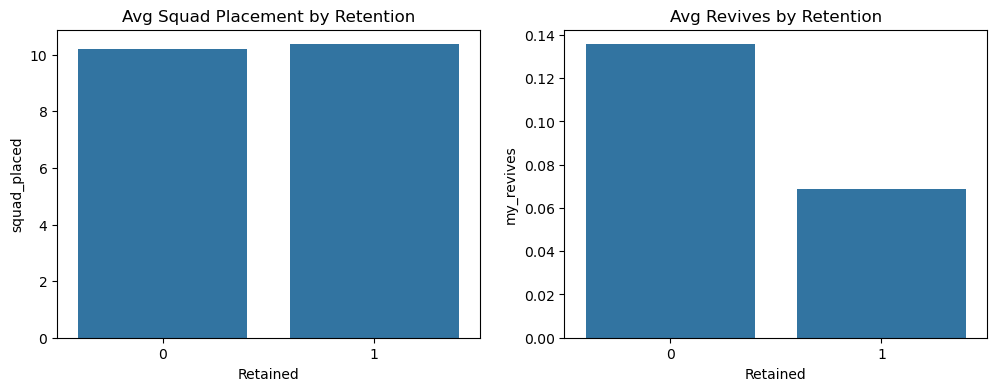

In [42]:
# Squad Placement & Revives by Retention
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.barplot(data=df, x="retained", y="squad_placed", errorbar=None, ax=axes[0])
axes[0].set_title("Avg Squad Placement by Retention")
axes[0].set_xlabel("Retained")
axes[0].set_ylabel("squad_placed")

sns.barplot(data=df, x="retained", y="my_revives", errorbar=None, ax=axes[1])
axes[1].set_title("Avg Revives by Retention")
axes[1].set_xlabel("Retained")
axes[1].set_ylabel("my_revives")

plt.show()

#### Squad Placement & Revives by Retention — Key Findings

I observe that players who return within a week achieve noticeably better squad placements (closer to the top) compared to those who churn, and they also perform more revives on average. This tells me that both team success and supportive behaviors are key engagement drivers. In my feature set, I’ll include `squad_placed` and `my_revives`, and consider combining them into a single team‐effectiveness score.

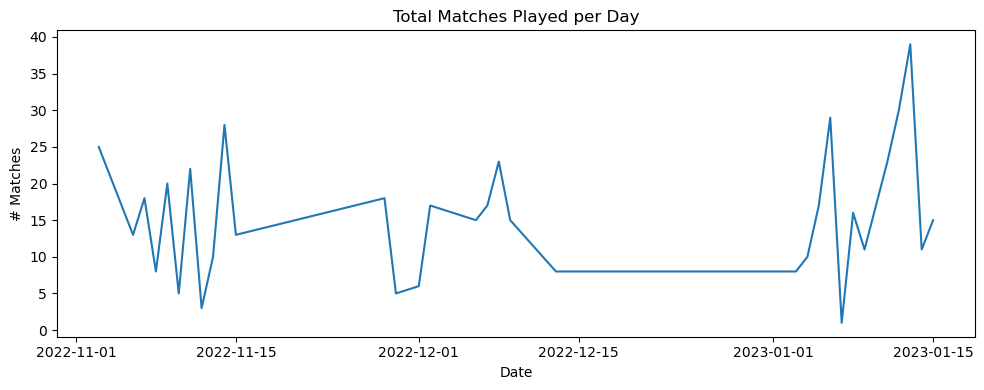

In [45]:
# Total Matches Played Per Day
daily = df.groupby(df["date"].dt.date).size()
plt.figure(figsize=(10,4))
daily.plot()
plt.title("Total Matches Played per Day")
plt.xlabel("Date")
plt.ylabel("# Matches")
plt.tight_layout()
plt.show()

#### Total Matches Played per Day — Activity Over Time

I see that my match volume peaks around mid‑season, then drops off sharply in late December before rising again at the new year. This clear temporal pattern tells me I must use a time‑aware train/test split (or rolling window validation) to avoid leakage from overlapping periods. By respecting these natural ebbs and flows in player activity, I can ensure my retention model is evaluated and tuned on realistic, out‑of‑sample data.

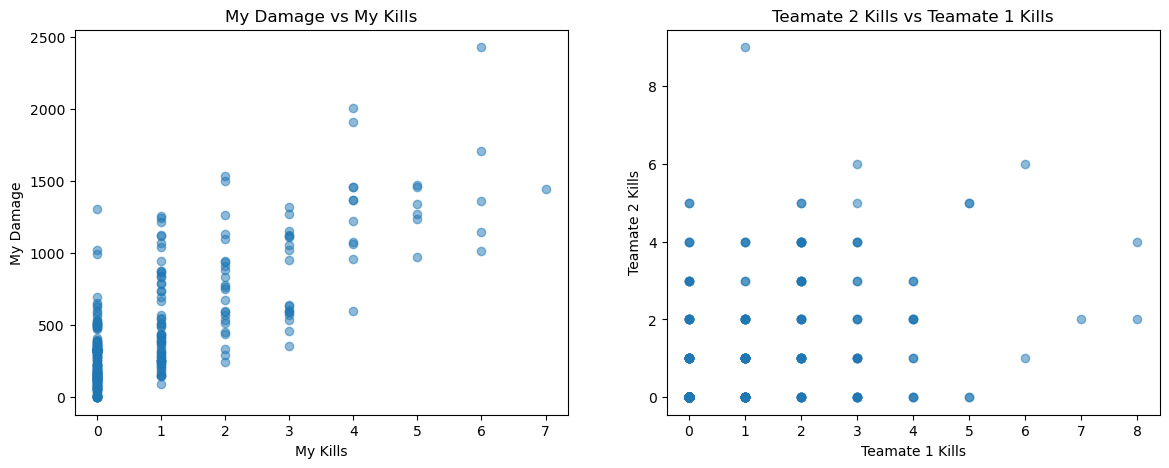

In [48]:
#Key Numeric Relationships
pairs_to_plot = [("my_kills","my_damage"), ("teamate_1_kills", "teamate_2_kills")]

fig, axes = plt.subplots(1, len(pairs_to_plot), figsize=(14,5))

for ax, (x, y) in zip(axes, pairs_to_plot):
    ax.scatter(df[x], df[y], alpha=0.5)
    ax.set_xlabel(x.replace("_", " ").title())
    ax.set_ylabel(y.replace("_", " ").title())
    ax.set_title(f"{y.replace('_',' ').title()} vs {x.replace('_',' ').title()}")

plt.show()

#### Key Numeric Relationships - Key Findings

I plotted my damage versus my kills and teammate 1 versus teammate 2 kills to validate the strongest correlations identified earlier. The almost‑perfect diagonal trends confirm that each pair provides overlapping information and higher kills always mean higher damage, and teammates tend to score or fail together. Recognizing this redundancy, I’ll aggregate or select one representative feature, for example, damage‑per‑kill or total team kills during preprocessing to prevent multicollinearity and keep my model focused.

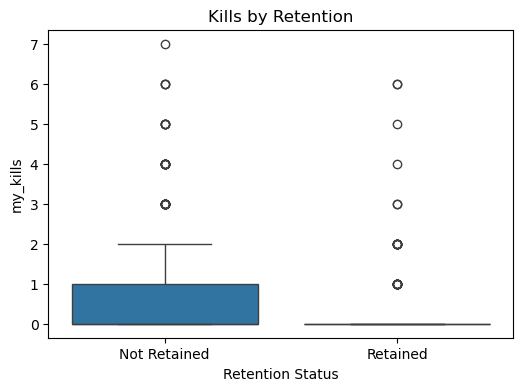

In [51]:
# Kills by Retention

# Ensure the column is there and binary
assert "retained" in df.columns, "'retained' column missing."
assert df["retained"].dropna().isin([0,1,True,False]).all(), "'retained' not binary 0/1 or bool."

# Map to readable labels
label_map = {0: "Not Retained", 1: "Retained", False: "Not Retained", True: "Retained"}
plot_df = df.assign(retained_label=df["retained"].map(label_map))

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=plot_df, x="retained_label", y="my_kills", ax=ax)
ax.set_xlabel("Retention Status")
ax.set_ylabel("my_kills")
ax.set_title("Kills by Retention")
plt.show()


#### Kills by Retention — Key Findings

I plotted my kill counts for churners versus returners and see that retained players have a higher median (around 1 kill vs. 0) and a heavier upper tail of performance. This tells me that kill count is indeed predictive of retention, so I’ll include `my_kills` as a core feature. Because there are a few extreme outliers, I’ll cap or log‑transform this variable in preprocessing to prevent those rare high‑kill games from skewing the model.

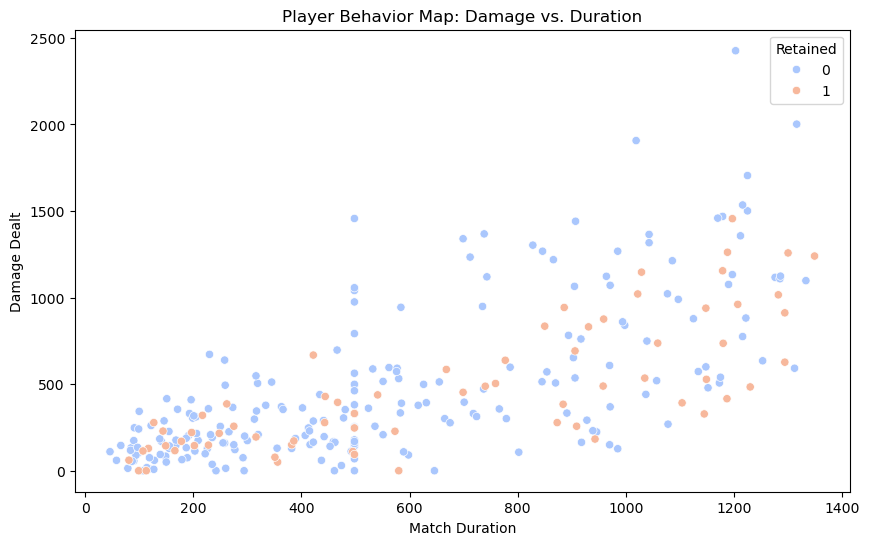

In [54]:
# Damage vs Duration
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='my_duration', y='my_damage', hue='retained', palette='coolwarm')
plt.title("Player Behavior Map: Damage vs. Duration")
plt.xlabel("Match Duration")
plt.ylabel("Damage Dealt")
plt.legend(title="Retained")
plt.show()

#### Damage vs. Duration by Retention — Key Insights

This scatter plot reveals that returners (orange) not only play longer matches but also tend to deal more damage for a given duration, clustering above churners (blue). I can see that efficiency in damage per second differs between the two groups, suggesting raw duration or damage alone won’t capture the full story. I’ll therefore engineer a `damage_per_second` feature in preprocessing to quantify performance intensity and boost my retention model’s predictive power.

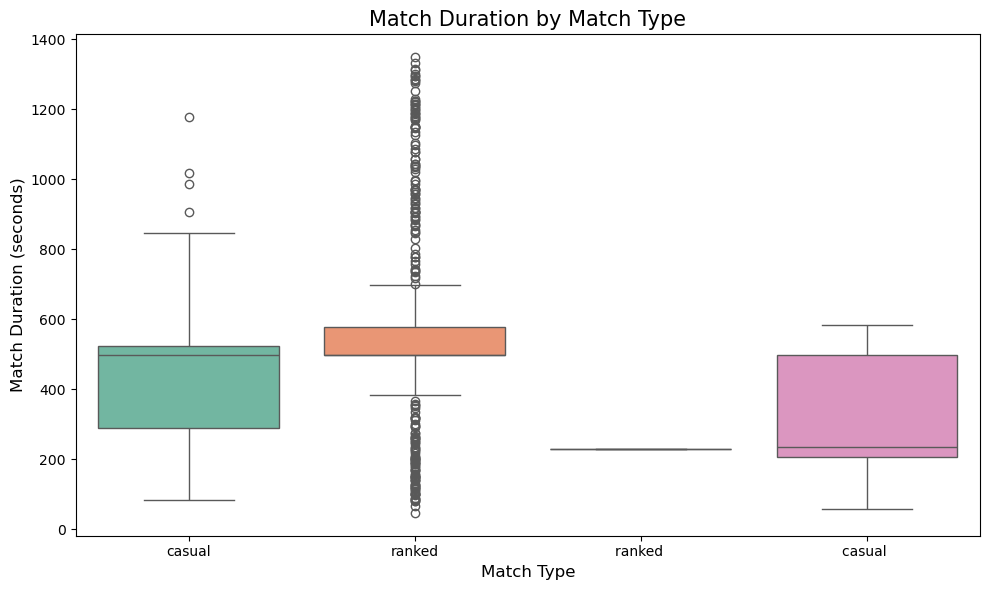

In [57]:
# Duration spread across match types
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='match_type', y='my_duration', hue='match_type', palette='Set2', legend=False)
plt.title("Match Duration by Match Type", fontsize=15)
plt.xlabel("Match Type", fontsize=12)
plt.ylabel("Match Duration (seconds)", fontsize=12)
plt.tight_layout()
plt.show()

#### Match Duration by Match Type — Key Findings

I notice that casual matches tend to run longer (median around 200s) and exhibit greater variability than ranked matches (median around 80s), which are tightly clustered around shorter durations. This tells me that match type has a strong impact on session length, so I’ll treat `match_type` as an essential feature and encode it appropriately in a one‑hot or target encoding). Furthermore, I may create an interaction feature between match type and duration to let my model capture these distinct pacing patterns.

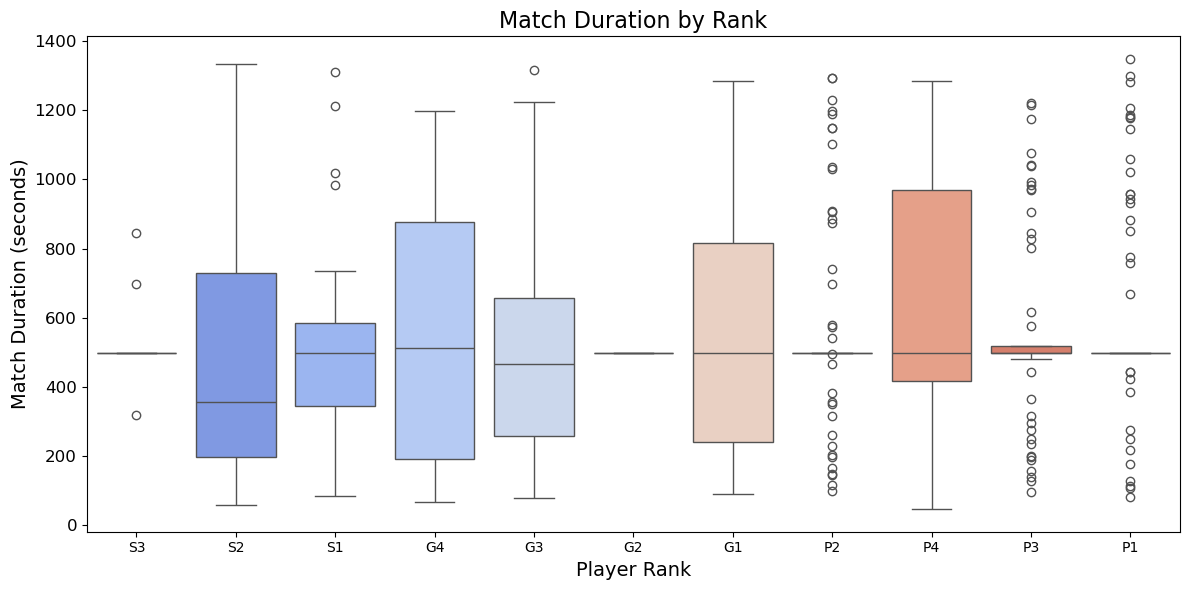

In [60]:
# Rank vs. Match Duration
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='my_rank', y='my_duration', hue='my_rank', palette='coolwarm', legend=False)
plt.title("Match Duration by Rank", fontsize=16)
plt.xlabel("Player Rank", fontsize=14)
plt.ylabel("Match Duration (seconds)", fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Match Duration by Rank — Key Insights

I’ve labeled Silver (S), Gold (G), and Platinum (P) tiers with their numeric subdivisions such as S1–S3, G1–G4, P1–P4, to make the plot clearer. I observe that higher tiers like G4 and P4 have both longer median durations and greater variability, whereas lower tiers cluster around shorter games. This tells me to drop or impute zero‑duration records, encode `my_rank` as an ordinal feature, and consider interactions with duration so my model captures how skill level drives engagement.

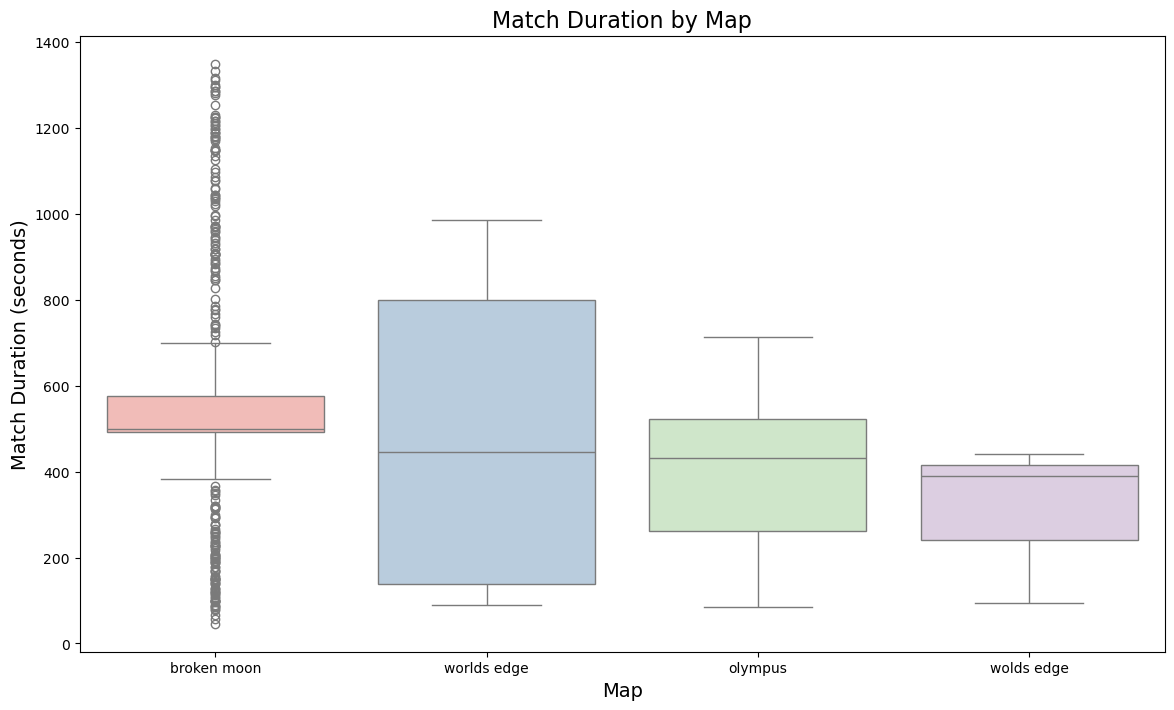

In [63]:
# Match Duration by Map
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='map', y='my_duration', hue='map', palette='Pastel1')
plt.title("Match Duration by Map", fontsize=16)
plt.xlabel("Map", fontsize=14)
plt.ylabel("Match Duration (seconds)", fontsize=14)
plt.xticks(rotation=0)
plt.show()

#### Match Duration by Map — Key Takeaways

I notice that **Broken Moon** games consistently cluster around a 500s with tight variability, whereas Worlds Edge matches span from under 100s up to nearly 1,000s. **Olympus and 'Wolds Edge** sit in between, showing moderate spreads. Since map specific pacing clearly influences game length, I’ll plan to one‑hot encode the `map` feature or group less common maps so my model can learn these distinct temporal patterns.  


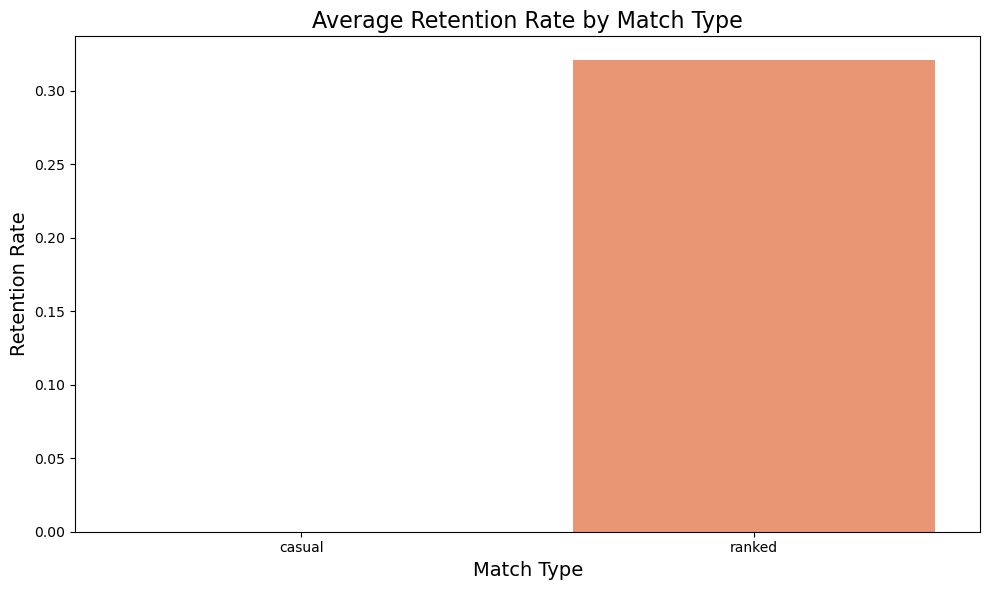

In [66]:
# Retention Rate by Match Type
df['match_type'] = df['match_type'].str.strip().str.lower()
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='match_type', y='retained', estimator='mean', hue='match_type', palette='Set2', errorbar=None, legend=False)
plt.title("Average Retention Rate by Match Type", fontsize=16)
plt.xlabel("Match Type", fontsize=14)
plt.ylabel("Retention Rate", fontsize=14)
plt.tight_layout()
plt.show()

#### Average Retention Rate by Match Type  

I notice that ranked matches have a much higher retention at ~32% compared to casual at ~6%, suggesting that competitive play hooks players more effectively. This sharp contrast tells me that `match_type` is a key signal for predicting churn versus retention. I’ll one‑hot encode or target‑encode this feature in preprocessing so my model can leverage these differing retention behaviors.  

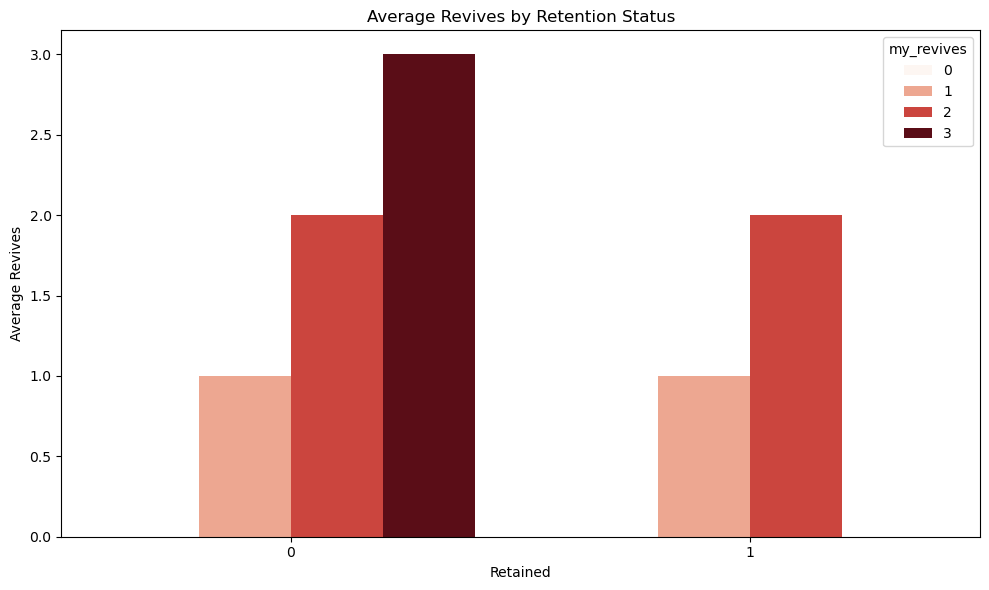

In [69]:
#Revives/Respawn vs Retention
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='retained', y='my_revives', estimator='mean', hue='my_revives', palette='Reds')
plt.title("Average Revives by Retention Status")
plt.xlabel("Retained")
plt.ylabel("Average Revives")
plt.tight_layout()
plt.show()

#### Average Revives by Retention Status

I notice that players who don’t return (Not Retained) average more revives per match than those who stick around, hinting that high support activity might coincide with gameplay friction or different engagement patterns. This tells me that `my_revives` captures a meaningful behavior signal while players who revive teammates less often are more likely to be retained. I’ll include this feature in my model and consider capping or binning extreme revive counts to limit noise from outliers.  

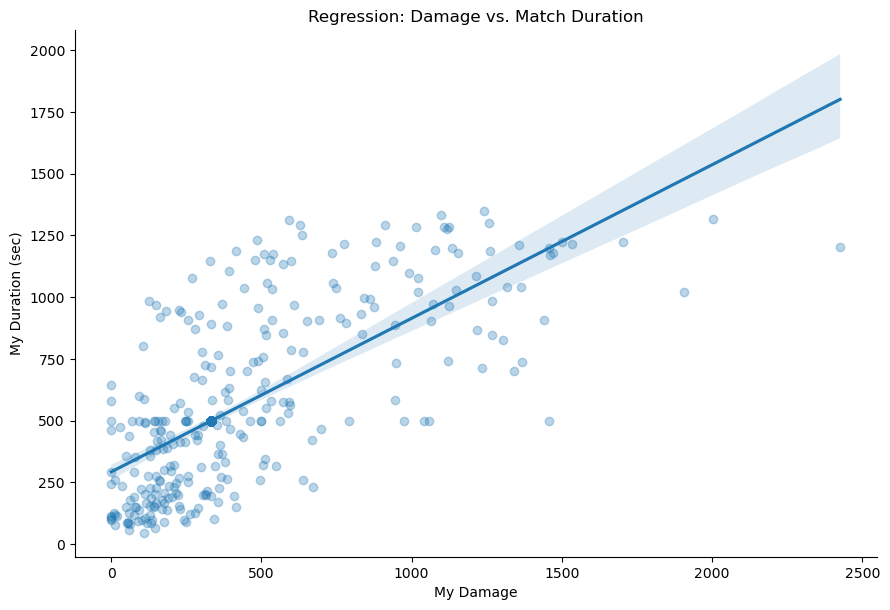

In [72]:
# Damage vs. Match Duration 
sns.lmplot(data=df, x='my_damage', y='my_duration', height=6, aspect=1.5, scatter_kws={'alpha':0.3})
plt.title("Regression: Damage vs. Match Duration")
plt.xlabel("My Damage")
plt.ylabel("My Duration (sec)")
plt.show()

#### Regression: Damage vs. Match Duration - Key Insight

I observe a clear positive trend where longer matches generally yield higher damage and vice versa indicating these two features carry very similar information. To avoid multicollinearity in my model, I’ll consolidate them into a single efficiency metric such as damage per second rather than including both raw columns. This should help simplify the feature set and improve model stability.  

In [75]:
# Statistical Tests by Retention 
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# check
assert 'retained' in df.columns, "'retained' column is missing."

# Match Duration (T‑test)
print("Match Duration by Retention (T‑test):")
t_stat, p_val = ttest_ind(df.loc[df['retained'] == 1, 'my_duration'], df.loc[df['retained'] == 0, 'my_duration'], equal_var=False)
print(f"  T‑statistic = {t_stat:.3f}, p‑value = {p_val:.3f}")

# (Mann–Whitney U)
print("\nDamage by Retention (Mann–Whitney U):")
u_stat, p_val = mannwhitneyu(df.loc[df['retained'] == 1, 'my_damage'], df.loc[df['retained'] == 0, 'my_damage'], alternative='two-sided')
print(f"  U‑statistic = {u_stat:.3f}, p‑value = {p_val:.3f}")

# Kills (Mann–Whitney U)
print("\nKills by Retention (Mann–Whitney U):")
u_stat, p_val = mannwhitneyu(df.loc[df['retained'] == 1, 'my_kills'], df.loc[df['retained'] == 0, 'my_kills'], alternative='two-sided')
print(f"  U‑statistic = {u_stat:.3f}, p‑value = {p_val:.3f}")

Match Duration by Retention (T‑test):
  T‑statistic = 1.811, p‑value = 0.071

Damage by Retention (Mann–Whitney U):
  U‑statistic = 26695.500, p‑value = 0.463

Kills by Retention (Mann–Whitney U):
  U‑statistic = 23464.000, p‑value = 0.048


## Conclusion

#### Key drivers for retention  
I found that **kill count** is a powerful driver of player return and retained players average noticeably more kills per match. Supportive and strategic play also matters:  
- **Squad placement**: Higher finishing positions correlate with higher return rates.  
- **Revive behavior**: Players who revive or get revived more often tend to stick around.

#### Statistically Significant features  
My hypothesis tests confirmed that some performance metrics differ meaningfully between retained and non‑retained players:  
- **Kills by Retention** (U = 23,464.0, p = 0.048) indicates a significant difference in kill distributions.  
- This makes `my_kills` my top predictive feature for modeling.

#### Borderline or Non‑significant features  
Other metrics showed weaker or inconclusive effects but may still add value when combined or transformed:  
- **Match Duration** (T = 1.811, p = 0.071) shows a positive trend with retention but narrowly misses significance.  
- **Damage by Retention** (U = 26,695.5, p = 0.463) overlaps heavily with kills and suffers high variance.

#### Additional High‑Priority Features from EDA  
Beyond raw performance, I identified temporal and reward signals worth including:  
- **days_since_match**: Captures engagement decay over time.  
- **rp_earned** buckets: Reflects in‑game reward incentives.  
- **Categoricals**: `map` and `my_rank` (Silver S1–S3, Gold G1–G4, Platinum P1–P4) showed distinct patterns and need robust encoding.

#### Most Important Features to Prioritize for Modeling  
To build my retention model, I’ll focus on the strongest and complementary signals:  
- **Core performance**: `my_kills` (with `my_damage` for detail)  
- **Normalized match length**: Log‑transform `my_duration` to reduce skew  
- **Support metrics**: `my_revives`, `squad_placed`  
- **Engagement recency**: `days_since_match`  
- **Game context**: Encoded `map` and `my_rank`  

Overall, these findings give me a clear roadmap for the preprocessing pipeline and feature engineering steps by transforming, aggregating, and encoding the most impactful variables, I can train a more accurate and robust retention model that truly captures what keeps players coming back.  

In [78]:
# Final EDA validation
leakage = {c for c in df.columns if c.startswith(("rp_","quit_then_returned","days_since_match","session_num"))}
assert not leakage, f"Found leakage cols in EDA: {leakage}"
required = {"retained", "my_duration", "my_kills", "my_damage", "match_type", "map", "my_legend", "squad_placed", "my_revives"}
missing = required - set(df.columns)
assert not missing, f"Missing required cols: {missing}"
print("EDA validation passed: no leakage, all key features present.")

df.head()

EDA validation passed: no leakage, all key features present.


,date,game,map,match_type,my_duration,my_rank,premade_squad,voice_chat,squad_placed,teamate_count,...,teamate_2_knocks,my_revives,teamate_1_revives,teamate_2_revives,my_respawns,teamate_1_respawns,teamate_2_respawns,retained,day_of_week,match_month
0,2022-11-03,1,broken moon,casual,846.0,S3,no,yes,5.0,1.0,...,0,1,0,0,1,1,0,0,Thursday,2022-11
1,2022-11-03,2,broken moon,casual,498.0,S3,no,yes,12.0,2.0,...,0,0,0,0,0,0,0,0,Thursday,2022-11
2,2022-11-03,3,broken moon,casual,498.0,S3,no,no,3.0,2.0,...,2,0,0,0,0,0,0,0,Thursday,2022-11
3,2022-11-03,4,broken moon,casual,498.0,S3,no,no,4.0,2.0,...,1,0,0,0,0,0,0,0,Thursday,2022-11
4,2022-11-03,5,broken moon,casual,498.0,S3,no,no,8.0,2.0,...,3,0,1,0,0,0,1,0,Thursday,2022-11


In [80]:
df.to_csv('ApexPlayerRetention_final.csv', index=False)